## Load Data

In [1]:
library(devtools)
# library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
# library(quantmod)
# library(xts)
# library(zoo)
library(gridExtra)
# library(tibble)
library(grid)
# library(future)
# library(future.apply)
# library(DescTools)
# library(rcompanion)
# library(tidyverse)
library(parallel)

source("forecast_research/finance/markets_functions.R")
load_all("forecast_research/vendor/hmmTMB")
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")
options(warn = -1)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
close_data_log <- read.csv("close_data_log.csv")
state_probs_df <- read.csv("state_probs_df.csv")

In [9]:
train_size <- as.integer(nrow(close_data_log) * 0.6)
validation_size <- as.integer(nrow(close_data_log) * 0.2)
test_size <- nrow(close_data_log) - train_size - validation_size

### For each step of the test set, do a one step forecast and get the state probabilites

In [4]:
cross_entropy_loss <- function(y_true, y_hat) {
  # Add small epsilon to avoid log(0)
  epsilon <- 1e-12
  y_hat <- pmax(pmin(y_hat, 1 - epsilon), epsilon)
  array(-rowSums(y_true * log(y_hat)))
}

In [14]:
tsx_training_data

,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500,Date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000000000,0.000000e+00,0.000000000,0.0000000000,0.000000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000000,0.000000000,0.000000000,0.0000000000,2007-01-05
2,-0.0116465098,-1.163241e-02,-0.066013779,-0.0141578196,-0.038033472,3.206809e-03,-6.939892e-04,-1.240555e-03,-0.0081373865,-0.009092800,0.013029062,0.0045696011,2007-01-12
3,0.0142746125,8.381472e-03,-0.050084328,0.0254144810,-0.025427679,-1.312185e-03,-2.184286e-03,-2.983604e-03,0.0158873241,0.017844508,0.033424269,0.0069904592,2007-01-19
4,0.0150837450,6.714436e-03,0.052188372,0.0217597229,0.024345976,6.747064e-03,-1.987927e-04,-2.988563e-04,0.0366682412,0.022524700,0.012988120,-0.0009175773,2007-01-26
5,0.0117739463,4.858434e-03,0.051212167,0.0075836685,-0.027072621,-8.133260e-04,-6.961145e-04,-1.794978e-03,0.0264998252,0.013504568,0.026282840,0.0062730155,2007-02-02
6,0.0079017175,1.100146e-02,0.032706197,0.0120763937,-0.025338179,6.781591e-05,4.268597e-03,2.591729e-03,-0.0003259239,0.017297794,0.026705396,0.0081836125,2007-02-09
7,0.0034705762,-4.392166e-04,-0.009128428,0.0144279115,0.050476257,-1.106192e-02,-9.904722e-05,1.094479e-03,-0.0055981461,0.021458617,-0.007507295,0.0018493216,2007-02-16
8,0.0098397888,9.183070e-03,0.027130734,0.0133489390,0.047561193,-3.287546e-03,4.152256e-03,3.672632e-03,0.0138258787,0.025431825,0.001542317,0.0051401401,2007-02-23
9,-0.0180535767,-1.318139e-02,0.026268110,-0.0092731612,0.020514719,5.359231e-03,4.429784e-03,6.813145e-03,-0.0094509369,-0.035902450,-0.049655453,-0.0337708891,2007-03-02


In [10]:
forecast_horizon <- 10
tsx_training_data <- close_data_log[1:train_size, , drop = FALSE]
tsx_model <- fit_hmm(
  n_states = 3,
  data = tsx_training_data,
  obs_name = "TSX_Composite",
  hid_formula = as.formula("~1"),
  horseshoe = FALSE,
  init = NULL
)
true_model <- fit_hmm(
  n_states = 3,
  data = close_data_log,
  obs_name = "TSX_Composite",
  hid_formula = as.formula("~1"),
  horseshoe = FALSE,
  init = tsx_model
)
true_state_probs <- true_model$state_probs()
state_losses <- matrix(NA, nrow = test_size, ncol = forecast_horizon)
predictions <- array(NA, dim = c(test_size, forecast_horizon, 3))
ground_truth <- array(NA, dim = c(test_size, forecast_horizon, 3))
j <- 1
for (i in (nrow(close_data_log)-test_size):(nrow(close_data_log) - forecast_horizon)) {
  fitting_data <- close_data_log[(i-150):i, , drop = FALSE]
  Y_true <- true_state_probs[(i+1):(i+forecast_horizon), c("state1", "state2", "state3")]
  tsx_forecast <- fit_hmm(
    n_states = 3,
    data = fitting_data,
    obs_name = "TSX_Composite",
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = tsx_model
  )
  forecaster <- Forecast$new(
    hmm = tsx_forecast,
    n = forecast_horizon,
    preset_eval_range = list(TSX_Composite = seq(from=-0.15, to=0.15, by=0.001))
  )
  Y_hat <- t(forecaster$hidden_state_forecast())
  predictions[j, , ] <- Y_hat
  ground_truth[j, , ] <- Y_true
  loss <- cross_entropy_loss(
    Y_true,
    Y_hat
  )
  state_losses[j, ] <- loss
  j <- j + 1
}

In [12]:
tsx_model

#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Estimated observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.006  -0.002   0.003
TSX_Composite.sd     0.045   0.019   0.009

#########################
## State process model ##
#########################
        state 1 state 2 state 3
state 1       .      ~1      ~1
state 2      ~1       .      ~1
state 3      ~1      ~1       .

> Estimated transition probabilities (t = 1):
        state 1 state 2 state 3
state 1   0.974   0.026   0.000
state 2   0.004   0.951   0.045
state 3   0.000   0.051   0.949


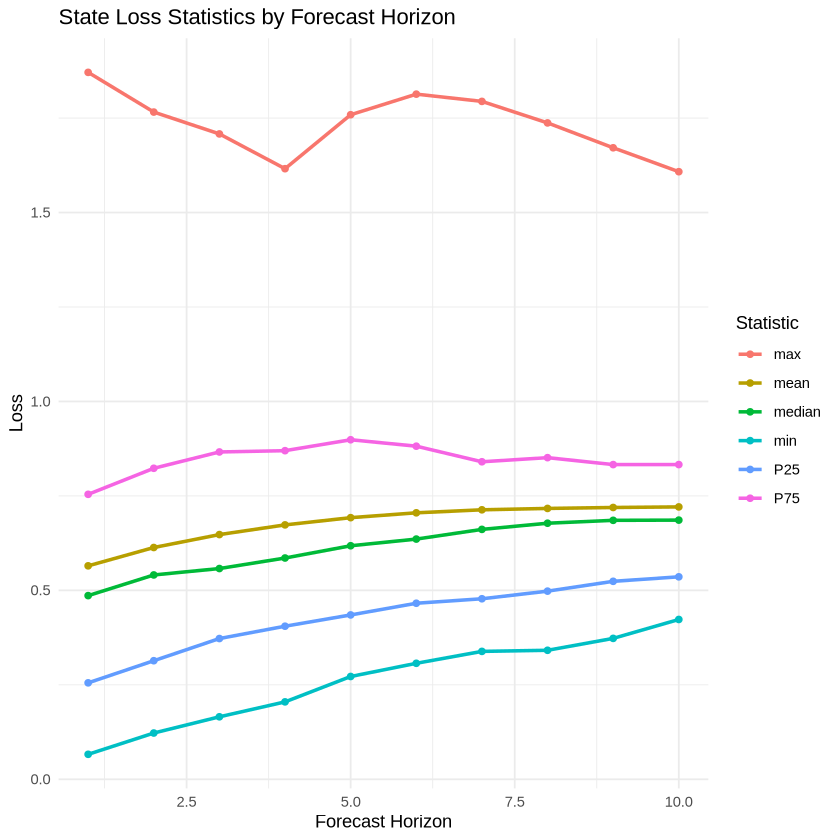

In [7]:
# Compute statistics for each forecast horizon (column)
stats_df <- data.frame(
  Horizon = 1:ncol(state_losses),
  mean = apply(state_losses, 2, mean, na.rm = TRUE),
  median = apply(state_losses, 2, median, na.rm = TRUE),
  P25 = apply(state_losses, 2, quantile, probs = 0.25, na.rm = TRUE),
  P75 = apply(state_losses, 2, quantile, probs = 0.75, na.rm = TRUE),
  max = apply(state_losses, 2, max, na.rm = TRUE),
  min = apply(state_losses, 2, min, na.rm = TRUE)
)

# Reshape for plotting
library(tidyr)
stats_long <- pivot_longer(stats_df, cols = -Horizon, names_to = "Statistic", values_to = "Value")

# Plot
library(ggplot2)
ggplot(stats_long, aes(x = Horizon, y = Value, color = Statistic)) +
  geom_line(size = 1) +
  geom_point() +
  labs(title = "State Loss Statistics by Forecast Horizon",
       x = "Forecast Horizon",
       y = "Loss") +
  theme_minimal()

In [8]:
stats_df

Horizon,mean,median,P25,P75,max,min
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5649345,0.4861006,0.2552475,0.7541983,1.870970,0.06607955
2,0.6134397,0.5407934,0.3138169,0.8231038,1.765886,0.12241203
3,0.6476653,0.5577770,0.3725108,0.8663165,1.708039,0.16538655
4,0.6733099,0.5856354,0.4051470,0.8697109,1.616012,0.20488105
5,0.6924281,0.6180930,0.4349874,0.8986061,1.758840,0.27205499
6,0.7052575,0.6357528,0.4659170,0.8815764,1.813326,0.30699094
7,0.7132186,0.6613977,0.4777787,0.8403347,1.794145,0.33848033
8,0.7168457,0.6777077,0.4979516,0.8512443,1.737189,0.34141985
9,0.7193559,0.6853475,0.5239492,0.8328813,1.671376,0.37290605


In [35]:
saveRDS(stats_df, "hmm_stats_df.rds")
saveRDS(state_losses, "hmm_state_losses.rds")
saveRDS(predictions, "hmm_predictions.rds")
saveRDS(ground_truth, "hmm_ground_truth.rds")